In [1]:
import torch
import torchvision.models as models
import clip
import difflib
import torchvision
import json

import os
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

from PIL import Image

import matplotlib.pyplot as plt

In [2]:
def load_resnet50_imagenet():
    # Load the ResNet-50 model pre-trained on ImageNet
    return models.resnet50(pretrained=True)

def load_clip_resnet50_vis():
    # Load the CLIP model, specify "RN50" to match ResNet-50 architecture
    model, preprocess = clip.load("RN50")
    return model.visual, preprocess

In [3]:
def compare_architectures():
    # Initialize the models
    resnet50_imagenet = load_resnet50_imagenet()
    clip_resnet50_visual, _ = load_clip_resnet50_vis()

    # Compare architectures
    imagenet_arch = str(resnet50_imagenet)
    clip_arch = str(clip_resnet50_visual)

    imagenet_arch_lines = str(resnet50_imagenet).split('\n')
    clip_arch_lines = str(clip_resnet50_visual).split('\n')

    d = difflib.Differ()
    diff = d.compare(imagenet_arch_lines, clip_arch_lines)

    return '\n'.join(diff)

output = compare_architectures()
# Specify the file path
file_path = "./diff.txt"

with open(file_path, "w") as file:
    file.write(output)


/home2/poorvi.c/miniconda3/envs/research/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home2/poorvi.c/miniconda3/envs/research/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Differences in the 2 architectures


Layer Modifications: The CLIP model features adjustments in layer configurations, such as changes in convolution layer parameters (e.g., the number of filters and kernel sizes). This likely aims to tune the model's sensitivity to features that are more relevant for joint image-text representations.


Additional Layers and Non-linearities: CLIP's ResNet includes additional ReLU activation layers and batch normalization layers interspersed within the architecture. This could potentially enhance non-linear learning capabilities, making it more effective at handling the diverse and complex patterns found in a dataset that combines visual and textual data.


Pooling Changes: Instead of the typical max pooling found in the standard ResNet-50, CLIP employs average pooling at various points, which might help in retaining more information about the overall structure of the input images. The attention pooling mechanism towards the end of the CLIP model underscores its design for handling complex associations between visual features and text.


Output Layer Adjustments: The standard ResNet-50 ends with a fully connected layer designed for 1000 specific ImageNet classes, reflecting its use for direct image classification tasks. In contrast, the CLIP version concludes with an attention pooling layer followed by a projection into a smaller feature space (1024-dimensional), aligning with its role in matching image features with text embeddings, rather than classifying into predefined categories.

### What label hierarchy is used in ImageNet? 

ImageNet uses a hierarchy derived from the WordNet hierarchy. In this structure, each concept,
or 'synset', is represented by a unique ID (e.g., 'n01440764') and is defined not only by the label
('tench, Tinca tinca') but also by its relationship to other concepts. Synsets are organized into
a tree that reflects real-world general-to-specific relationships, with more general terms at the
top and more specific terms below.

### What does a synset mean?

A 'synset' in ImageNet refers to a 'synonym set', a group of synonymous words or phrases that share
the same meaning but may have different visual appearances. Each synset corresponds to a node in
the WordNet hierarchy and represents a single concept.

### Could grouping objects based on synsets lead to problems for visual recognition? 

Grouping objects based on synsets can lead to issues in visual recognition due to:  
    1. Intra-class variation: Objects in the same synset can look very different from each other.  
    2. Contextual ambiguity: The same object may appear differently in different contexts.  
    3. Scale and orientation: Variations in size, scale, and orientation can complicate recognition.  

### State 3 types of visual differences we can expect to see in images with objects corresponding to the same synset

Within the same synset, we can expect to see visual differences such as:  
    1. Color variations: Different objects might share the same form but differ in color.  
    2. Age and wear: Objects like tools or vehicles can appear new or aged, affecting their visual recognition.  
    3. Breed or type variations: For example, the dog synset includes various breeds that look drastically different.  
    


In [ ]:
def load_clip(device):
    model, preprocess = clip.load('RN50', device)
    model.eval()
    return model, preprocess

def prepare_text_inputs(class_idx_to_label, device):
    descriptions = [f"a photo of a {label}" for label in class_idx_to_label.values()]
    text_inputs = clip.tokenize(descriptions).to(device)
    return text_inputs

def load_class_mappings(filepath):
    with open(filepath, 'r') as file:
        content =  file.read()
    local_vars = {}
    exec(f"dictionary = {content}", {}, local_vars)
    return local_vars['dictionary']

def load_symnet_class_mappings(filepath):
    d_n = dict()
    with open(filepath, 'r') as file:
        content =  file.read()
    local_vars = {}
    exec(f"dictionary = {content}", {}, local_vars)
    d =  local_vars['dictionary']
    for key in d:
        d_n[d[key]["id"].split("-")[1] + d[key]["id"].split("-")[0]] = d[key]["label"]
    return d_n
def load_symnet_id_mappings(filepath):
    d_n = dict()
    with open(filepath, 'r') as file:
        content =  file.read()
    local_vars = {}
    exec(f"dictionary = {content}", {}, local_vars)
    d =  local_vars['dictionary']
    for key in d:
        d_n[d[key]["label"]] = key
    return d_n

symnet_map = load_symnet_class_mappings("./data/mapping_symidx.txt")
symnet_idx = load_symnet_id_mappings("./data/mapping_symidx.txt")


In [5]:
def predict_clip_zero_shot(model, preprocess, text_inputs, image_paths, device, class_idx_to_label,  plot = True, analyze = False):
    with torch.no_grad():
        for path in image_paths:
            label = symnet_map[path.split('/')[-2]]

            if path.split('/')[1] == 'clip_s':
                image = Image.open(path).convert('L')
                image_tensor = preprocess(image.convert('RGB')).unsqueeze(0).to(device)
            else:
                image = Image.open(path)
                image_tensor = preprocess(image).unsqueeze(0).to(device)

            # image_disp = Image.open(path,)
            # image = preprocess(Image.open(path)).unsqueeze(0).to(device)
           
            image_logits,_= model(image_tensor, text_inputs)
            probabilities=image_logits.softmax(dim=-1)[0]


            top_probs, top_labels = probabilities.topk(5)

            if not analyze:
            
                print(f"Results for {path}:")
                for prob, idx in zip(top_probs, top_labels):
                    print(f"{class_idx_to_label[idx.item()]}: {prob.item() * 100:.3f}%")
                print("\n")

            if plot:
                plt.figure(figsize=(8, 10))
                if path.split('/')[1] == 'clip_s':
                    plt.imshow(image,cmap='gray')
                else:
                    plt.imshow(image)
                plt.title(label)
                plt.axis('off')
                plt.show()
            
            if analyze:
                if int(symnet_idx[label]) in top_labels[0]:
                    return True
                else:
                    return False
    
def predict_resnet50_zero_shot(model, preprocess, image_paths, device, class_idx_to_label, plot = True, analyze = False):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        for path in image_paths:
            # Load and preprocess the image
            label = symnet_map[path.split('/')[-2]]

            if path.split('/')[1] == 'clip_s':
                image = Image.open(path).convert('L')
                image_tensor = preprocess(image.convert('RGB')).unsqueeze(0).to(device)
            else:
                image = Image.open(path)
                image_tensor = preprocess(image).unsqueeze(0).to(device)

            # Get predictions
            outputs = model(image_tensor)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)
            top_probs, top_labels = probabilities.topk(5)

            # Display results
            if not analyze:
                print(f"Results for {path}:")
                for prob, idx in zip(top_probs[0], top_labels[0]):
                    print(f"{class_idx_to_label[idx.item()]}: {prob.item() * 100:.3f}%")
                print("\n")

            # Show the image
            if plot:
                plt.figure(figsize=(8, 10))
                if path.split('/')[1] == 'clip_s':
                    plt.imshow(image,cmap='gray')
                else:
                    plt.imshow(image)
                plt.title(label)
                plt.axis('off')
                plt.show()
            
            if analyze:
                if int(symnet_idx[label]) in top_labels[0]:
                    return True
                else:
                    return False
                


def clip_eval(image_paths, plot = True, analyze = False):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model, preprocess = load_clip(device)
    class_idx_to_label = load_class_mappings('./data/mapping.txt')
    text_inputs = prepare_text_inputs(class_idx_to_label, device)
    return(predict_clip_zero_shot(model, preprocess, text_inputs, image_paths, device, class_idx_to_label,plot, analyze))

def resnet50_eval(image_paths, plot=True, analyze=False):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    class_idx_to_label = load_class_mappings('./data/mapping.txt')

    model = load_resnet50_imagenet()

    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    return(predict_resnet50_zero_shot(model, preprocess, image_paths, device, class_idx_to_label, plot, analyze))




In [15]:
import shutil
import random
from glob import glob

def process_images(base_dir, output_dir1, output_dir2):
    train_path = os.path.join(base_dir, 'train')
    val_path = os.path.join(base_dir, 'val')
    categories = [d for d in os.listdir(train_path) if os.path.isdir(os.path.join(train_path, d))]
    
    # Randomly select 20 classes
    selected_categories = random.sample(categories, min(30, len(categories)))

    for category in selected_categories:
        # Process each image in the category from both train and val
        for sub_dir in ['train', 'val']:
            current_path = os.path.join(base_dir, sub_dir, category)
            for image_path in glob(os.path.join(current_path, '*.*')):  # Adjust the pattern if needed
                try:
                    f1 = clip_eval(image_paths=[image_path], plot=False, analyze=True)
                    f2 = resnet50_eval(image_paths=[image_path], plot=False, analyze=True)
                except:
                    continue
                if f1 < f2:
                    dest_dir = os.path.join(output_dir1, category)
                elif f1 > f2:
                    dest_dir = os.path.join(output_dir2, category)
                else:
                    continue
                
                if not os.path.exists(dest_dir):
                    os.makedirs(dest_dir)
                shutil.copy(image_path, dest_dir)
    
base_dir = './data/imagenet-mini'
output_dir1 = './results/clip_success'
output_dir2 = './results/resnet50_success'

# process_images(base_dir, output_dir1, output_dir2)

CLIP Successes:
Clip
Results for ./results/clip_success/n01873310/sketch_26.JPEG:
platypus, duckbill, duckbilled platypus, duck-billed platypus, Ornithorhynchus anatinus: 83.887%
koala, koala bear, kangaroo bear, native bear, Phascolarctos cinereus: 5.850%
electric ray, crampfish, numbfish, torpedo: 2.300%
plate: 0.589%
plastic bag: 0.360%




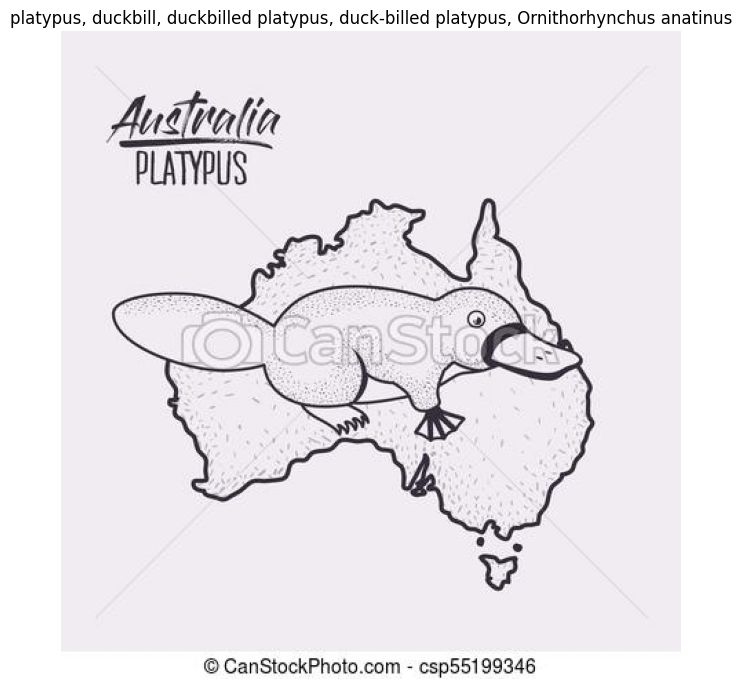

Results for ./results/clip_success/n01873310/sketch_17.JPEG:
platypus, duckbill, duckbilled platypus, duck-billed platypus, Ornithorhynchus anatinus: 17.430%
barracouta, snoek: 16.838%
tench, Tinca tinca: 10.270%
electric ray, crampfish, numbfish, torpedo: 9.332%
coho, cohoe, coho salmon, blue jack, silver salmon, Oncorhynchus kisutch: 5.520%




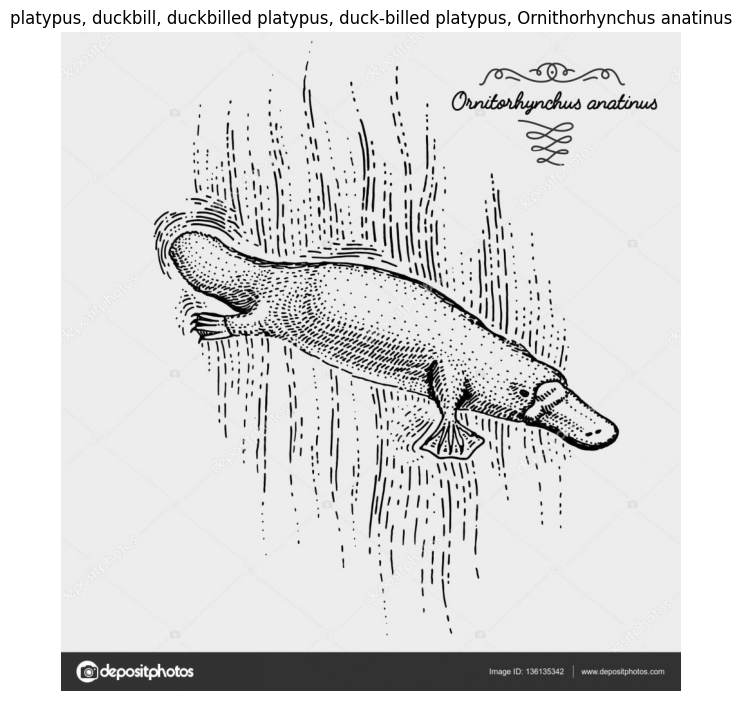

Resnet50
Results for ./results/clip_success/n01873310/sketch_26.JPEG:
jigsaw puzzle: 48.415%
envelope: 35.815%
rubber eraser, rubber, pencil eraser: 2.982%
jersey, T-shirt, tee shirt: 0.800%
laptop, laptop computer: 0.724%




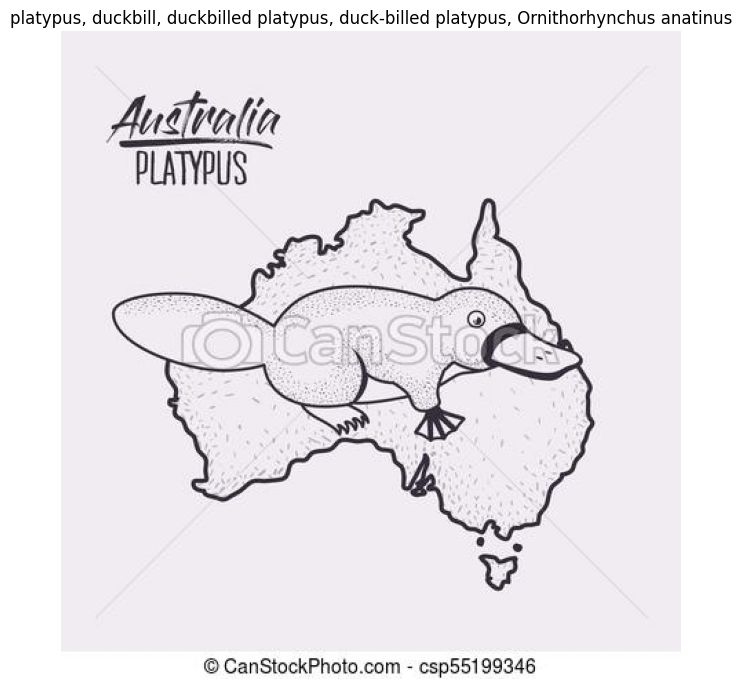

Results for ./results/clip_success/n01873310/sketch_17.JPEG:
American alligator, Alligator mississipiensis: 27.415%
coho, cohoe, coho salmon, blue jack, silver salmon, Oncorhynchus kisutch: 9.407%
African crocodile, Nile crocodile, Crocodylus niloticus: 7.909%
armadillo: 4.982%
letter opener, paper knife, paperknife: 4.315%




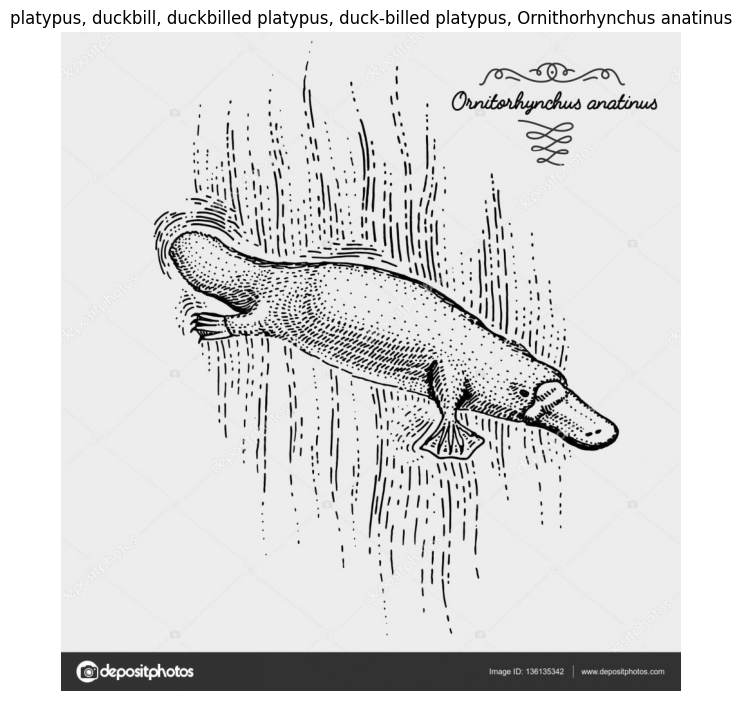



Resnet50 Successes:
Clip
Results for ./results/resnet50_success/n01873310/n01873310_11445.JPEG:
Dungeness crab, Cancer magister: 15.800%
tench, Tinca tinca: 14.492%
electric ray, crampfish, numbfish, torpedo: 10.565%
axolotl, mud puppy, Ambystoma mexicanum: 9.063%
eel: 6.777%




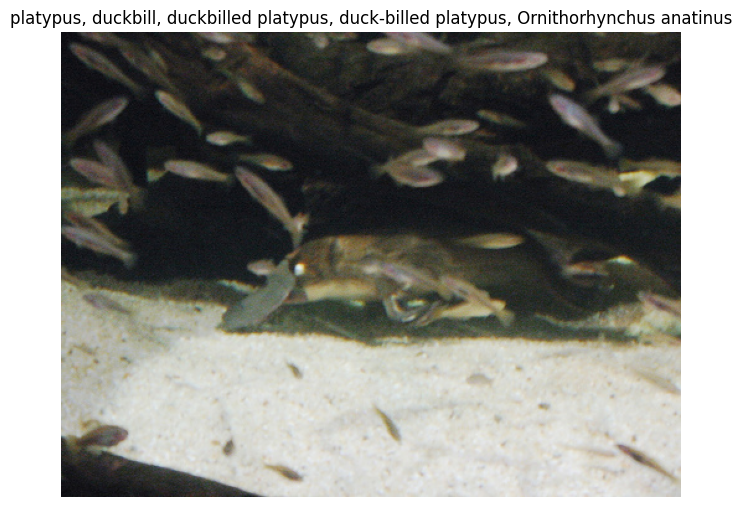

Resnet50
Results for ./results/resnet50_success/n01873310/n01873310_11445.JPEG:
platypus, duckbill, duckbilled platypus, duck-billed platypus, Ornithorhynchus anatinus: 99.336%
puffer, pufferfish, blowfish, globefish: 0.207%
crayfish, crawfish, crawdad, crawdaddy: 0.097%
Dungeness crab, Cancer magister: 0.077%
fiddler crab: 0.030%




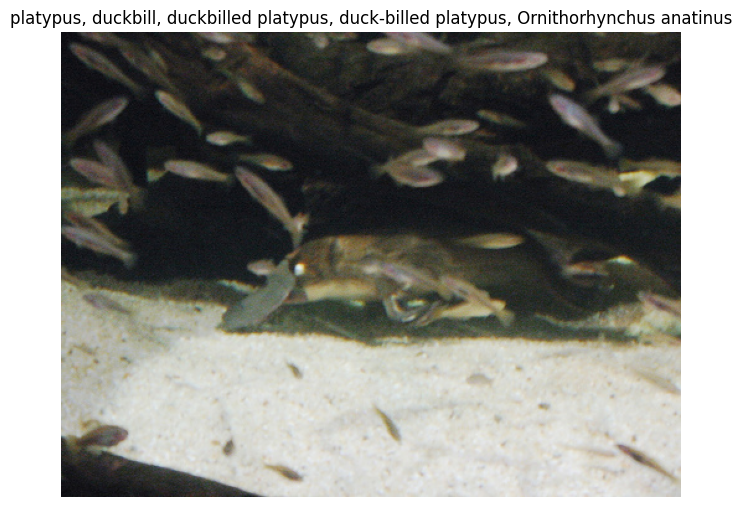

In [40]:
clip_s = os.listdir(output_dir1)
clip_s.sort()
clip_s_list = [
    os.path.join(output_dir1, i) for i in clip_s[3:4]
]

clip_s_list_images = glob(os.path.join(clip_s_list[0], '*.*'))

resnet50_s = os.listdir(output_dir2)
resnet50_s.sort()
resnet50_s_list = [
    os.path.join(output_dir2, i) for i in resnet50_s[3:4]
]

resnet50_s_list_images = glob(os.path.join(resnet50_s_list[0], '*.*'))

print("CLIP Successes:")
print("Clip")
clip_eval(clip_s_list_images, plot=True, analyze=False)
print("Resnet50")
resnet50_eval(clip_s_list_images, plot=True, analyze=False)
print("\n")
print("Resnet50 Successes:")
print("Clip")
clip_eval(resnet50_s_list_images, plot=True, analyze=False)
print("Resnet50")
resnet50_eval(resnet50_s_list_images, plot=True, analyze=False)

### How did I find the images where clip succeeds?

I took images from Imagenet-Sketch, a dataset which CLIP was robust too but Imagenet Pretrained ResNet was not. CLIP is more genralizable due as it is used in the zero-shot sense here after being trained on muc more genral web data. While Resnet is affcted by the distribution priors of Imagenet

### What are the failure cases of CLIP
Clip is sensitive to textual elements of the image, while Resnet is not. This is helpful in certain images, and unhelpful in order cases where signboards may be misleading.

These images have been taken fro the val set of imagenet

In [ ]:
import os
import time
import torch
import numpy as np
from torchvision.models import resnet50
from torchvision.models.resnet import ResNet50_Weights
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
from PIL import Image
from tqdm import tqdm

# Set device for computation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load models
def load_model(half_precision=False):
    model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1).to(device)
    if half_precision:
        model = model.half()
    return model

torch_resnet50 = load_model()
torch_resnet50_fp16 = load_model(half_precision=True)

# Preprocessing pipeline
preprocess = Compose([
    Resize(256),
    CenterCrop(224),
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Function to load and preprocess image
def load_and_preprocess_image(img_path, half=False):
    try:
        img = Image.open(img_path).convert("RGB")
        img_tensor = preprocess(img).unsqueeze(0).to(device)
        if half:
            img_tensor = img_tensor.half()
        return img_tensor
    except IOError:
        print(f"Error opening image {img_path}")
        return None

# Function to encode image and measure time taken
def encode_image_timed(model, img_tensor):
    with torch.no_grad():
        start_time = time.time()
        output = model(img_tensor)
        end_time = time.time()
    return output, end_time - start_time

# Function to time model encoding over multiple images
def time_encoding(model, image_paths, half=False, iterations=10):
    times = []
    for _ in tqdm(range(iterations), desc="Timing Model"):
        for img_path in image_paths:
            img_tensor = load_and_preprocess_image(img_path, half)
            if img_tensor is not None:
                _, time_taken = encode_image_timed(model, img_tensor)
                times.append(time_taken)
    return np.mean(times), np.std(times)

# Directory and image paths
directory = "/kaggle/input/imagenetmini-1000/imagenet-mini/train/n01440764"
image_paths = [os.path.join(directory, name) for name in os.listdir(directory)]

# Time encoding
mean_fp32, std_fp32 = time_encoding(torch_resnet50, image_paths)
mean_fp16, std_fp16 = time_encoding(torch_resnet50_fp16, image_paths, half=True)

print(f"FP32: Mean = {mean_fp32:.6f}s, STD = {std_fp32:.6f}")
print(f"FP16: Mean = {mean_fp16:.6f}s, STD = {std_fp16:.6f}")

# Comparing probabilities
def compare_probs(model_fp32, model_fp16, image_paths, labels):
    results = {}
    for img_path, label in zip(image_paths, labels):
        img_tensor_fp32 = load_and_preprocess_image(img_path)
        img_tensor_fp16 = load_and_preprocess_image(img_path, half=True)
        probs_fp32, _ = encode_image_timed(model_fp32, img_tensor_fp32)
        probs_fp16, _ = encode_image_timed(model_fp16, img_tensor_fp16)
        results[label] = (probs_fp32.cpu().numpy(), probs_fp16.cpu().numpy())
    return results

# Image paths and labels for comparison
image_paths = [
    "/kaggle/input/imagenetmini-1000/imagenet-mini/train/n01440764/n01440764_10043.JPEG",
    "/kaggle/input/imagenetmini-1000/imagenet-mini/train/n01496331/n01496331_11594.JPEG",
    "/kaggle/input/imagenetmini-1000/imagenet-mini/train/n01443537/n01443537_10092.JPEG",
    "/kaggle/input/imagenetmini-1000/imagenet-mini/train/n01484850/n01484850_1199.JPEG",
    "/kaggle/input/imagenetmini-1000/imagenet-mini/train/n01491361/n01491361_10000.JPEG"
]
labels = [
    "tench, Tinca tinca",
    "electric ray, crampfish, numbfish, torpedo",
    "goldfish, Carassius auratus",
    "great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias",
    "tiger shark, Galeocerdo cuvieri"
]

prob_results = compare_probs(torch_resnet50, torch_resnet50_fp16, image_paths, labels)
for label, (probs_fp32, probs_fp16) in prob_results.items():
    print(f"{label}\nFP32 Top Probabilities: {probs_fp32[:5]}\nFP16 Top Probabilities: {probs_fp16[:5]}\n{'-'*10}")


### Analysis

The memory usage by the fp32 and fp16 model looks quite comparable fro the images, but the peaks from the fp32 model are much higher indicating that theere are few layers in both architectures that account for high memory usage by the model

#### fp16 model

![image.png](./half.jpeg)

#### fp32 model

![image.png](./full.jpeg)


#### Mean and std deviation of time taken to enocde images

Mean and std for fp16 run: 0.010978, 0.000797  
Mean and std for fp32 run: 0.011322s, 0.000993 

As you can see, while the difference is very smal, the fp16 model takes slightly less time to enocde images as compared to the fp32 model